In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import keras.utils
import tensorflow as tf

from keras import layers
from keras import models

import anchor as ac
import utils
import preprocessing as pp

import importlib
import os

import keras.backend as K

Using TensorFlow backend.


# Model 

In [90]:
#configuration
# for anchors
input_shape = (224, 224, 3) 
ss = [0.1, 0.2, 0.3]
r = [1, 0.5, 1.5, 0.75]
variance = np.array([0.1, 0.1, 0.2, 0.2])
n_boxes = len(r)
mode = 'training'
batch_size = 4


# for data_generator:
mafa_paths = {i: os.path.join('data', i) for i in os.listdir('data')}

# get path to train, test data
train_images_path = mafa_paths['train_images']
train_labels_path = os.path.join(mafa_paths['train_labels'], 'LabelTrainAll.mat')
test_images_path = mafa_paths['test_images']
test_labels_path = os.path.join(mafa_paths['test_labels'], 'LabelTestAll.mat')
train_key = 'label_train'
test_key = 'LabelTest'

neg_iou_threshold = 0.1
iou_threshold = 0.6

#for prediction
score_threshold = 0.2
iou_threshold = 0.5
top_k_boxes = 10



In [79]:
#create partition of train and test images from test folder
ids = os.listdir(test_images_path)
labels = pp.get_labels(test_images_path, test_labels_path, test_key)

In [80]:
partition = {'train':ids[:30], 'test':ids[-30:]}

In [81]:
def res_block(_input, filters, kernel_size ):
    y = layers.Conv2D(filters= filters, kernel_size= kernel_size, padding= 'same')(_input)
    y = layers.BatchNormalization()(y)
    y = layers.Activation('relu')(y)
    y = layers.Conv2D(filters= filters, kernel_size= kernel_size, padding= 'same')(y)
    y = layers.BatchNormalization()(y)
    _input = layers.Conv2D(filters= filters, kernel_size=1)(_input)
    y = layers.add([_input, y])
    y = layers.Activation('relu')(y)
#     y = layers.SpatialDropout2D(dropout_rate)(y)
    return y

In [82]:
from keras.applications import ResNet50

conv_base = ResNet50(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


In [91]:
input_data = conv_base.input
name= "res3b_branch2a"

x3= conv_base.get_layer(name).output 
x3 = layers.BatchNormalization()(x3)
x3 = layers.Activation('relu')(x3)
x3 = res_block(_input= x3, filters= 128, kernel_size= 3)
x3_1 = layers.MaxPool2D(strides= 2)(x3)

x4 = res_block(_input= x3_1, filters= 128, kernel_size= 3)
x4_1 = layers.MaxPool2D(strides= 2)(x4)

x5 = res_block(_input= x4_1, filters= 128, kernel_size= 3)
# x5 = layers.Conv2D(filters= 128, kernel_size= 3, padding= 'same')(x4_1)
# x5 = layers.BatchNormalization()(x5)
# x5 = layers.Activation('relu')(x5)

# output = layers.Reshape((-1, 2))(x7)
# print(output)

## bow build upon some predictor layers (b, total_boxes, 2 + 4)
pretictor_layers = [x3, x4, x5]

cls_preds = [layers.Conv2D(n_boxes*2, 3, padding= 'same')(x) for x in pretictor_layers ]
# reshape each predict to(b, -1, 2)
cls_preds = [layers.Reshape((-1, 2))(pred) for pred in cls_preds]
# concat all cls pred (b, total_box, 2)
cls_pred = layers.Concatenate(axis= 1)(cls_preds)
cls_pred = layers.Activation('softmax')(cls_pred)

reg_preds = [layers.Conv2D(n_boxes*4, 3, padding= 'same')(x) for x in pretictor_layers ]
# reshape each predict to(b, -1, 2)
reg_preds = [layers.Reshape((-1, 4))(pred) for pred in reg_preds]
# concat all cls pred (b, total_box, 2)
reg_pred = layers.Concatenate(axis= 1)(reg_preds)


if mode == 'training':
    #concat cls and boxes coordinates prediction
    output = layers.Concatenate(axis= -1)([cls_pred, reg_pred])
    
elif mode == 'predicting':
    
    ### anchor boxes for inference (b, total_boxes, 8)
    anchor_tensors = [ac.Anchor(s, r, variance)(x) for x, s in zip(pretictor_layers,ss)]
    anchor_tensor = layers.Concatenate(axis= 1)(anchor_tensors)
    
    # concat anchor tensor to prediction for inference purpose
    y_pred = layers.Concatenate(axis= -1)([cls_pred, reg_pred, anchor_tensor])
#     output = y_pred
    output = utils.DecodePred( score_threshold, iou_threshold, top_k_boxes)(y_pred)
else: 
    raise ValueError('not a valid mode')
    
model = models.Model(inputs = input_data, outputs = output)

# Predict

In [66]:
img_path = train_images_path + '/'+ os.listdir(train_images_path)[2]
img = pp.preprocess_image(img_path)

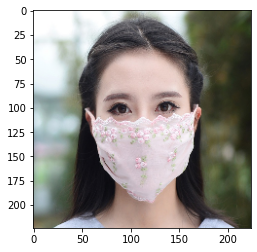

In [67]:
plt.imshow(img)

In [68]:
pred = model.predict(np.expand_dims(img, axis= 0))

In [72]:
pred[0,:,-1]>0.5 

array([False, False, False, ..., False, False, False])

In [49]:
pred.shape

(1, 4116, 14)

In [9]:
model.trainable = True

set_trainable = False
for layer in model.layers:
    if layer.name == 'res3b_branch2a':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [18]:
# model.summary()


# loss and compile

In [92]:
loss = utils.LossSSD()
model.compile(optimizer=keras.optimizers.RMSprop(0.001), loss=loss.compute_loss)

# Data Generator

In [93]:
### get fmap_shapes and anchor_boxes for labeling
fmap_shapes = [(x._keras_shape[1], x._keras_shape[2]) for x in pretictor_layers]
anchor_boxes = ac.all_anchor_boxes(fmap_shapes, ss, r)
label_anchor = ac.LabelAnchor(anchor_boxes, variance, iou_threshold, neg_iou_threshold)

In [94]:
train_generator = pp.DataGenerator(images_path = test_images_path, 
                                   list_ids = partition['train'], 
                                   labels = labels,
                                   label_anchor= label_anchor,
                                  batch_size = batch_size)

In [95]:
test_generator = pp.DataGenerator(images_path = test_images_path, 
                                   list_ids = partition['test'], 
                                   labels = labels,
                                   label_anchor= label_anchor,
                                 batch_size = batch_size)

# set up and run

In [97]:
model.fit_generator(generator=train_generator,
                    validation_data=test_generator,
                   use_multiprocessing= True,
                   workers= 6, epochs= 4)

Epoch 1/4
7/7 [==============================] - 7s 1s/step - loss: 0.1439 - val_loss: 12.5750
Epoch 2/4
7/7 [==============================] - 7s 959ms/step - loss: 0.0616 - val_loss: 4.9236e-10
Epoch 3/4
7/7 [==============================] - 7s 954ms/step - loss: 0.0811 - val_loss: 2.8962e-11
Epoch 4/4
7/7 [==============================] - 7s 949ms/step - loss: 0.0359 - val_loss: 2.2041e-08


In [19]:
help(ac.gen_anchor_tensor)

Help on function gen_anchor_tensor in module anchor:

gen_anchor_tensor(x, s, r, variance)
    input: tensor x , feature map of the predictor layer, shape of (b, h, w, c)
    ouput: tensor (b, nboxes, 4) 
    variance if an np.array of 4 elements

